# 🌤️ Stage 4: 外部要因分析

## 目的
**「なぜ売れた/売れなかったのか？」外部要因から理解する**

このノートブックでは、売上に影響を与える外部要因を分析します。

### 外部要因とは？
店舗や商品自体ではコントロールできないが、売上に影響する要素:
- **天気・気温**: 雨の日は傘が売れる、暑い日はアイスが売れる
- **曜日・休日**: 平日と休日で客層・購買行動が変わる
- **イベント**: 給料日、連休、学校休み等
- **季節性**: 月・週による季節変動

### 分析内容
1. **天気・気温の影響分析**
   - 気温と売上の相関
   - 天気（晴れ/雨）による売上の違い
   - カテゴリ別の気温感応度

2. **曜日・休日の影響分析**
   - 曜日パターン（Stage 1で実施済み）
   - 休日・連休の影響
   - 給料日前後の変化

3. **イベント要因の分析**
   - GW、お盆、年末年始等の大型連休
   - 学校休み期間
   - その他特殊要因

4. **複合要因の分析**
   - 「雨の日×休日」など複数要因の組み合わせ
   - 最も売上に影響する要因の特定

### 業務的な意義
- **発注担当**: 天気予報を見て発注量を調整できる
- **店長**: イベント前に適切な商品を準備できる
- **オーナー**: 売上変動の要因を理解し、適切な経営判断ができる

---

## 📦 1. 環境準備

In [ ]:
# 日本語フォント設定（共通モジュール）
import warnings
warnings.filterwarnings('ignore')

# よく使うライブラリを先に読み込む
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ウィジェットの有無を通知・フラグ化
try:
    import ipywidgets as widgets
    from IPython.display import display, HTML, clear_output
    WIDGETS_AVAILABLE = True
    print('✅ ipywidgets利用可能')
except Exception:
    WIDGETS_AVAILABLE = False
    print('⚠️ ipywidgets未インストール - 一部機能制限')

import font_setup
JP_FP = font_setup.setup_fonts(show_test=False)


In [2]:
import pandas as pd
from datetime import datetime, timedelta

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

## 📁 2. データ読み込み

In [3]:
file_path = 'output/06_final_enriched_20250701_20250930.csv'

print(f"📂 データ読み込み中: {file_path}")
df = pd.read_csv(file_path, encoding='utf-8-sig')
df['日付'] = pd.to_datetime(df['日付'])

print(f"\n✅ 読み込み完了")
print(f"   データ期間: {df['日付'].min().strftime('%Y-%m-%d')} 〜 {df['日付'].max().strftime('%Y-%m-%d')}")

# 利用可能な外部要因列を確認
print("\n📊 利用可能な外部要因特徴:")

# 天気関連
weather_cols = [col for col in df.columns if any(keyword in col for keyword in ['気温', '天気', '降水', '猛暑', '真夏', '雨'])]
print(f"\n  🌡️ 気温・天気関連: {len(weather_cols)}列")
if len(weather_cols) > 0:
    print(f"    例: {', '.join(weather_cols[:5])}...")

# カレンダー関連
calendar_cols = [col for col in df.columns if any(keyword in col for keyword in ['曜日', '休日', '連休', 'GW', '盆', '年末', '給料', '学校'])]
print(f"\n  📅 カレンダー関連: {len(calendar_cols)}列")
if len(calendar_cols) > 0:
    print(f"    例: {', '.join(calendar_cols[:5])}...")

# 季節指数
index_cols = [col for col in df.columns if '指数' in col]
print(f"\n  📈 季節・客数指数: {len(index_cols)}列")
if len(index_cols) > 0:
    print(f"    例: {', '.join(index_cols)}")

📂 データ読み込み中: output/06_final_enriched_20250701_20250930.csv

✅ 読み込み完了
   データ期間: 2025-07-01 〜 2025-09-30

📊 利用可能な外部要因特徴:

  🌡️ 気温・天気関連: 56列
    例: 天気, 最高気温, 最低気温, 降水量, 平均気温...

  📅 カレンダー関連: 21列
    例: 曜日, 休日フラグ, 休日タイプ, 休日前日, 休日翌日...

  📈 季節・客数指数: 9列
    例: 季節変動指数_月, 季節変動指数_週, 客数指数, 季節変動指数_月_t-1, 季節変動指数_変化量_月, 季節変動指数_変化率_月, 季節変動指数_週_t-1, 季節変動指数_変化量_週, 季節変動指数_変化率_週


## 🌡️ 3. 気温と売上の相関分析

### 業務的な意義
気温によって売れる商品が変わる → 天気予報を見て発注を調整できる

🌡️ 気温と売上の相関分析

最高気温との相関係数: -0.121
平均気温との相関係数: -0.091

------------------------------------------------------------
【相関係数の読み方】
  +1に近い → 気温が高いほど売上が増える
   0に近い → 気温と売上に関係がない
  -1に近い → 気温が低いほど売上が増える


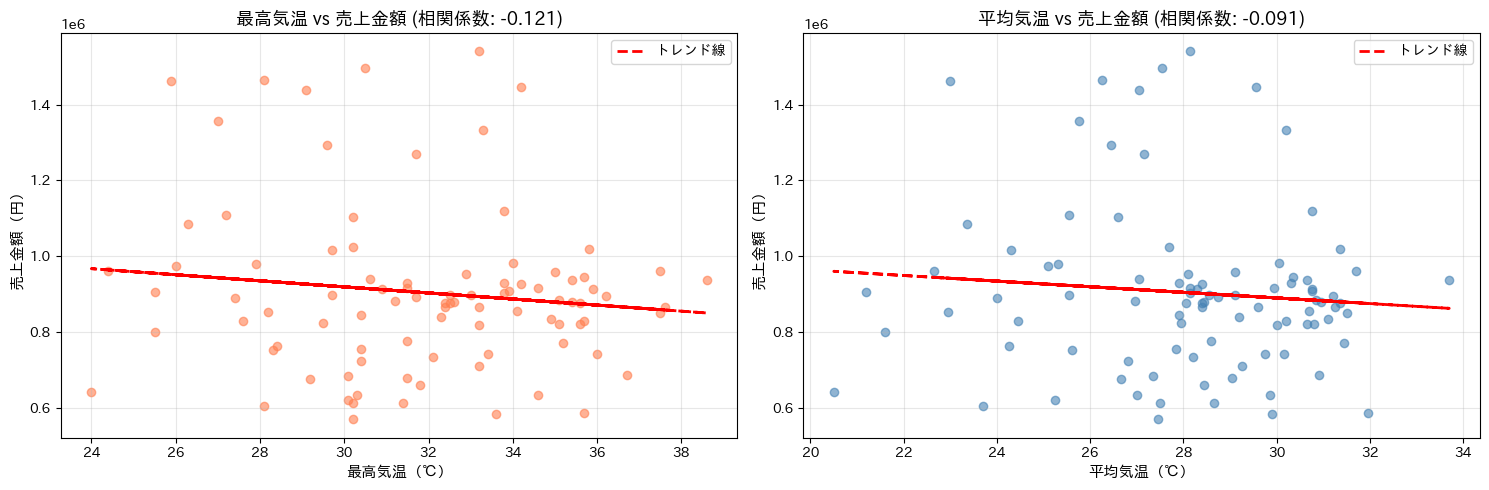

In [4]:
# 日次集計（気温データを含む）
if '最高気温' in df.columns and '平均気温' in df.columns:
    daily_summary = df.groupby('日付').agg({
        '売上金額': 'sum',
        '売上数量': 'sum',
        '最高気温': 'first',  # 日付ごとに1つの値
        '平均気温': 'first'
    }).reset_index()
    
    # 相関係数の計算
    corr_max_temp = daily_summary['売上金額'].corr(daily_summary['最高気温'])
    corr_avg_temp = daily_summary['売上金額'].corr(daily_summary['平均気温'])
    
    print("="*60)
    print("🌡️ 気温と売上の相関分析")
    print("="*60)
    print(f"\n最高気温との相関係数: {corr_max_temp:.3f}")
    print(f"平均気温との相関係数: {corr_avg_temp:.3f}")
    
    print("\n" + "-"*60)
    print("【相関係数の読み方】")
    print("  +1に近い → 気温が高いほど売上が増える")
    print("   0に近い → 気温と売上に関係がない")
    print("  -1に近い → 気温が低いほど売上が増える")
    
    # 散布図
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # 最高気温 vs 売上
    axes[0].scatter(daily_summary['最高気温'], daily_summary['売上金額'], alpha=0.6, color='coral')
    axes[0].set_title(f'最高気温 vs 売上金額 (相関係数: {corr_max_temp:.3f}, fontproperties=JP_FP)', fontsize=13)
    axes[0].set_xlabel('最高気温（℃）', fontsize=11, fontproperties=JP_FP)
    axes[0].set_ylabel('売上金額（円）', fontsize=11, fontproperties=JP_FP)
    axes[0].grid(True, alpha=0.3)
    
    # 回帰直線を追加
    z = np.polyfit(daily_summary['最高気温'], daily_summary['売上金額'], 1)
    p = np.poly1d(z)
    axes[0].plot(daily_summary['最高気温'], p(daily_summary['最高気温']), "r--", linewidth=2, label='トレンド線')
    axes[0].legend(prop=JP_FP)
    
    # 平均気温 vs 売上
    axes[1].scatter(daily_summary['平均気温'], daily_summary['売上金額'], alpha=0.6, color='steelblue')
    axes[1].set_title(f'平均気温 vs 売上金額 (相関係数: {corr_avg_temp:.3f}, fontproperties=JP_FP)', fontsize=13)
    axes[1].set_xlabel('平均気温（℃）', fontsize=11, fontproperties=JP_FP)
    axes[1].set_ylabel('売上金額（円）', fontsize=11, fontproperties=JP_FP)
    axes[1].grid(True, alpha=0.3)
    
    z = np.polyfit(daily_summary['平均気温'], daily_summary['売上金額'], 1)
    p = np.poly1d(z)
    axes[1].plot(daily_summary['平均気温'], p(daily_summary['平均気温']), "r--", linewidth=2, label='トレンド線')
    axes[1].legend(prop=JP_FP)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️ 気温データが見つかりません")

## 🌧️ 4. 天気（晴れ/雨）と売上の分析

### 業務的な意義
雨の日は来客数が減るが、特定商品（傘、弁当等）は売れる

🌧️ 天気（晴れ/雨）と売上の比較
      売上金額_合計  売上金額_平均   日数  売上数量_合計   指数
晴れ     47342048.0          972.0  48687       242782.0  100.0
雨       35806365.0         1064.0  33656       177469.0  109.0


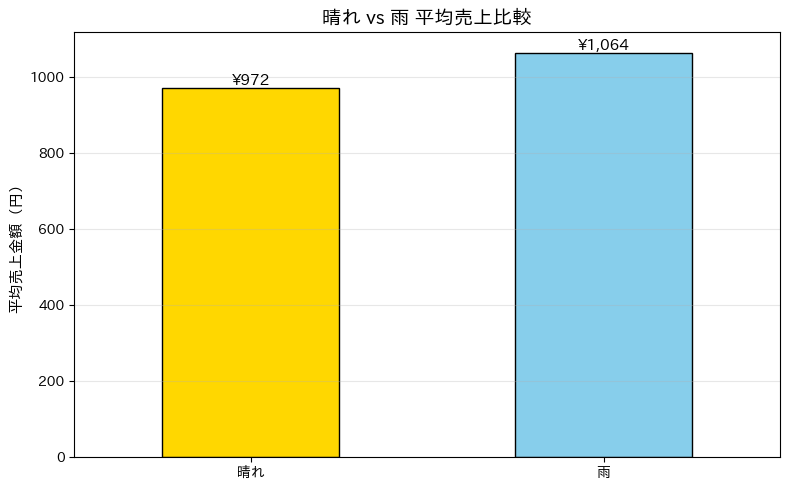


💡 業務への示唆
  → 雨の日は晴れの日より+9.5%売上が変動


In [5]:
# 降雨フラグがあるか確認
if '降雨フラグ' in df.columns:
    weather_comparison = df.groupby('降雨フラグ').agg({
        '売上金額': ['sum', 'mean', 'count'],
        '売上数量': 'sum'
    }).round(0)
    
    weather_comparison.columns = ['売上金額_合計', '売上金額_平均', '日数', '売上数量_合計']
    weather_comparison.index = ['晴れ', '雨']
    
    # 晴れを100としたインデックス
    weather_comparison['指数'] = (weather_comparison['売上金額_平均'] / 
                                   weather_comparison.loc['晴れ', '売上金額_平均'] * 100).round(0)
    
    print("="*60)
    print("🌧️ 天気（晴れ/雨）と売上の比較")
    print("="*60)
    print(weather_comparison.to_string())
    
    # グラフ化
    fig, ax = plt.subplots(figsize=(8, 5))
    weather_comparison['売上金額_平均'].plot(kind='bar', ax=ax, color=['gold', 'skyblue'], edgecolor='black')
    ax.set_title('晴れ vs 雨 平均売上比較', fontsize=14, fontproperties=JP_FP)
    ax.set_xlabel('', fontsize=11, fontproperties=JP_FP)
    ax.set_ylabel('平均売上金額（円）', fontsize=11, fontproperties=JP_FP)
    ax.set_xticklabels(['晴れ', '雨'], rotation=0)
    ax.grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(weather_comparison['売上金額_平均']):
        ax.text(i, v, f'¥{v:,.0f}', ha='center', va='bottom', fontsize=11, fontproperties=JP_FP)
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 業務への示唆")
    diff_pct = (weather_comparison.loc['雨', '売上金額_平均'] / 
                weather_comparison.loc['晴れ', '売上金額_平均'] - 1) * 100
    print(f"  → 雨の日は晴れの日より{diff_pct:+.1f}%売上が変動")
    if diff_pct < 0:
        print(f"  → 雨の日は客数が減るため、発注を抑えめにする")
    
else:
    print("⚠️ '降雨フラグ' 列が見つかりません")

## 🏷️ 5. カテゴリ別の気温感応度分析

### 業務的な意義
どのカテゴリが気温に敏感か理解し、天気予報に応じた発注をする

🏷️ カテゴリ別の気温感応度（気温との相関）
                  カテゴリ  気温相関係数
                220:化粧品      0.474085
          300:日本酒・焼酎      0.371078
                245:衣料品      0.266505
        125:日配品・生鮮品      0.242932
            215:ドライ飲料      0.173518
      165:インスタント食品      0.171501
      185:洋風菓子・駄菓子      0.139560
                105:調理麺      0.083233
                398:用度品      0.072959
190:和風菓子・珍味・豆菓子      0.064596
        140:カウンターＦＦ      0.039172
                295:ビール      0.009731
        225:バス・洗面用品     -0.004645
      280:チケット・カード     -0.022358
                  xxx:不明     -0.037696
                290:たばこ     -0.038388
                  120:惣菜     -0.040706
      205:健康サポート飲料     -0.048026
  265:雑誌・コミック・新聞     -0.051914
  250:文具・玩具・趣味雑貨     -0.069221
    170:乾物・缶詰・調味料     -0.073214
          305:ワイン・洋酒     -0.091355
              200:健康食品     -0.099493
          240:紙・衛生用品     -0.108755
          195:スナック菓子     -0.116061
                115:サラダ     -0.116790
      135:牛乳・チルド飲料     -0.12088

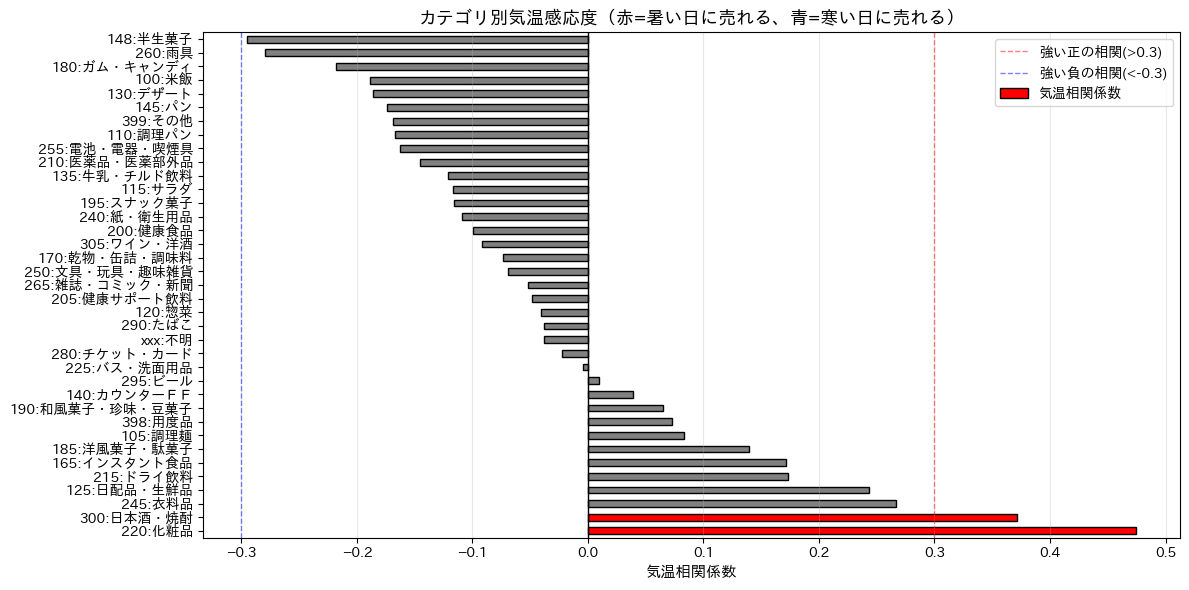

In [6]:
if '最高気温' in df.columns:
    # カテゴリ別・日次集計
    category_daily = df.groupby(['日付', 'フェイスくくり大分類']).agg({
        '売上金額': 'sum',
        '最高気温': 'first'
    }).reset_index()
    
    # カテゴリごとに気温との相関を計算
    category_temp_corr = []
    
    for category in df['フェイスくくり大分類'].unique():
        cat_data = category_daily[category_daily['フェイスくくり大分類'] == category]
        if len(cat_data) > 10:  # 十分なデータがある場合のみ
            corr = cat_data['売上金額'].corr(cat_data['最高気温'])
            category_temp_corr.append({
                'カテゴリ': category,
                '気温相関係数': corr
            })
    
    category_temp_df = pd.DataFrame(category_temp_corr).sort_values('気温相関係数', ascending=False)
    
    print("="*60)
    print("🏷️ カテゴリ別の気温感応度（気温との相関）")
    print("="*60)
    print(category_temp_df.to_string(index=False))
    
    print("\n" + "-"*60)
    print("【業務的な意味】")
    
    # 最も気温に敏感なカテゴリ
    top_positive = category_temp_df.iloc[0]
    top_negative = category_temp_df.iloc[-1]
    
    print(f"  暑い日に売れる: {top_positive['カテゴリ']} (相関: {top_positive['気温相関係数']:.3f})")
    print(f"  寒い日に売れる: {top_negative['カテゴリ']} (相関: {top_negative['気温相関係数']:.3f})")
    print(f"\n  → 天気予報で気温を確認し、これらのカテゴリの発注を調整する")
    
    # グラフ化
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['red' if x > 0.3 else 'blue' if x < -0.3 else 'gray' for x in category_temp_df['気温相関係数']]
    category_temp_df.plot(x='カテゴリ', y='気温相関係数', kind='barh', ax=ax, color=colors, edgecolor='black', legend=False)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax.axvline(x=0.3, color='red', linestyle='--', linewidth=1, alpha=0.5, label='強い正の相関(>0.3)')
    ax.axvline(x=-0.3, color='blue', linestyle='--', linewidth=1, alpha=0.5, label='強い負の相関(<-0.3)')
    ax.set_title('カテゴリ別気温感応度（赤=暑い日に売れる、青=寒い日に売れる）', fontsize=13, fontproperties=JP_FP)
    ax.set_xlabel('気温相関係数', fontsize=11, fontproperties=JP_FP)
    ax.set_ylabel('', fontsize=11, fontproperties=JP_FP)
    ax.legend(fontsize=10, prop=JP_FP)
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️ 気温データが見つかりません")

## 📅 6. イベント要因の分析

### 業務的な意義
連休・給料日などのイベント時に売上がどう変わるか理解する

In [7]:
# イベント関連のフラグ列を探す
event_flags = ['休日フラグ', '連休フラグ', 'GW期間フラグ', '給料日前後フラグ', '学校休み期間フラグ']
available_event_flags = [col for col in event_flags if col in df.columns]

if len(available_event_flags) > 0:
    print("="*60)
    print("📅 イベント要因別の売上分析")
    print("="*60)
    
    event_comparison = {}
    
    for event_col in available_event_flags:
        event_stats = df.groupby(event_col).agg({
            '売上金額': ['sum', 'mean', 'count']
        }).round(0)
        
        event_stats.columns = ['売上金額_合計', '売上金額_平均', '日数']
        
        # 基準値（通常日）を100としたインデックス
        base_value = event_stats.loc[0, '売上金額_平均'] if 0 in event_stats.index else event_stats['売上金額_平均'].iloc[0]
        event_stats['指数'] = (event_stats['売上金額_平均'] / base_value * 100).round(0)
        
        event_comparison[event_col] = event_stats
        
        print(f"\n【{event_col}】")
        print(event_stats.to_string())
    
    print("\n" + "-"*60)
    print("【業務的な意味】")
    print("  指数 > 100 → イベント時は売上が増える → 発注を増やす")
    print("  指数 < 100 → イベント時は売上が減る → 発注を減らす")
    
else:
    print("⚠️ イベント関連のフラグ列が見つかりません")

📅 イベント要因別の売上分析

【休日フラグ】
            売上金額_合計  売上金額_平均   日数   指数
休日フラグ                                            
0              60474705.0         1046.0  57835  100.0
1              22673708.0          925.0  24508   88.0

【連休フラグ】
            売上金額_合計  売上金額_平均   日数   指数
連休フラグ                                            
0              75911000.0         1017.0  74623  100.0
1               7237413.0          937.0   7720   92.0

------------------------------------------------------------
【業務的な意味】
  指数 > 100 → イベント時は売上が増える → 発注を増やす
  指数 < 100 → イベント時は売上が減る → 発注を減らす


## 🔥 7. 複合要因分析（雨×休日など）

### 業務的な意義
複数の要因が重なった時の影響を理解する（例: 雨の日の休日は？）

🔥 複合要因分析（天気×休日）
                   売上金額_合計  売上金額_平均   日数   指数
天気_休日パターン                                            
雨×平日               28344154.0         1092.0  25966  108.0
晴れ×平日             32130551.0         1008.0  31869  100.0
雨×休日                7462211.0          970.0   7690   96.0
晴れ×休日             15211497.0          904.0  16818   90.0


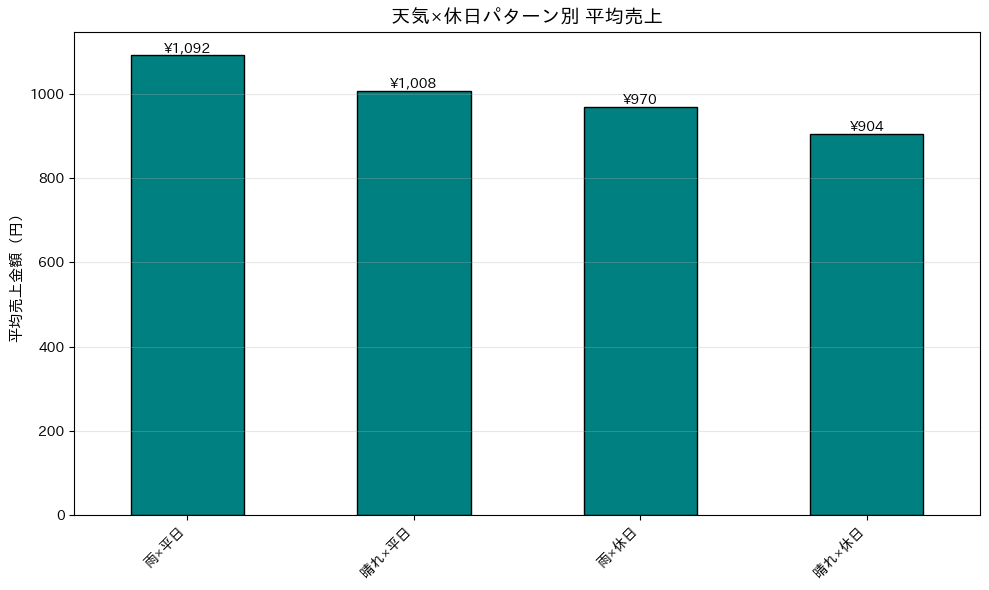


💡 業務への示唆
  → 最も売上が高い: 雨×平日
  → 最も売上が低い: 晴れ×休日
  → 天気予報と曜日を組み合わせて発注量を調整する


In [8]:
if '降雨フラグ' in df.columns and '休日フラグ' in df.columns:
    # 複合パターンの作成
    df['天気_休日パターン'] = df.apply(
        lambda row: '雨×休日' if row['降雨フラグ'] == 1 and row['休日フラグ'] == 1
        else '雨×平日' if row['降雨フラグ'] == 1 and row['休日フラグ'] == 0
        else '晴れ×休日' if row['降雨フラグ'] == 0 and row['休日フラグ'] == 1
        else '晴れ×平日',
        axis=1
    )
    
    # パターン別集計
    pattern_stats = df.groupby('天気_休日パターン').agg({
        '売上金額': ['sum', 'mean', 'count']
    }).round(0)
    
    pattern_stats.columns = ['売上金額_合計', '売上金額_平均', '日数']
    
    # 晴れ×平日を100としたインデックス
    base_value = pattern_stats.loc['晴れ×平日', '売上金額_平均']
    pattern_stats['指数'] = (pattern_stats['売上金額_平均'] / base_value * 100).round(0)
    
    # ソート
    pattern_stats = pattern_stats.sort_values('売上金額_平均', ascending=False)
    
    print("="*60)
    print("🔥 複合要因分析（天気×休日）")
    print("="*60)
    print(pattern_stats.to_string())
    
    # グラフ化
    fig, ax = plt.subplots(figsize=(10, 6))
    pattern_stats['売上金額_平均'].plot(kind='bar', ax=ax, color='teal', edgecolor='black')
    ax.set_title('天気×休日パターン別 平均売上', fontsize=14, fontproperties=JP_FP)
    ax.set_xlabel('', fontsize=11, fontproperties=JP_FP)
    ax.set_ylabel('平均売上金額（円）', fontsize=11, fontproperties=JP_FP)
    ax.set_xticklabels(pattern_stats.index, rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(pattern_stats['売上金額_平均']):
        ax.text(i, v, f'¥{v:,.0f}', ha='center', va='bottom', fontsize=10, fontproperties=JP_FP)
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 業務への示唆")
    best_pattern = pattern_stats.index[0]
    worst_pattern = pattern_stats.index[-1]
    print(f"  → 最も売上が高い: {best_pattern}")
    print(f"  → 最も売上が低い: {worst_pattern}")
    print(f"  → 天気予報と曜日を組み合わせて発注量を調整する")
    
else:
    print("⚠️ 降雨フラグまたは休日フラグが見つかりません")

## 📊 8. 特徴量重要度分析（売上への影響度ランキング）

### 業務的な意義
どの外部要因が最も売上に影響するか特定し、優先的に注目する

📊 特徴量重要度（売上金額との相関）

【正の相関（上位20）】
→ 値が大きいほど売上が増える要因
  気温差_変化量_1d: 0.045
  気温差_大: 0.039
  季節変動指数_変化率_月: 0.033
  気温差: 0.031
  季節変動指数_変化量_月: 0.031
  気温差_拡大: 0.030
  季節変動指数_変化率_週: 0.029
  平日フラグ: 0.029
  季節変動指数_変化量_週: 0.026
  降雨フラグ: 0.023
  季節変動指数_週: 0.017
  弱雨: 0.016
  季節_上昇期: 0.016
  客数指数: 0.015
  季節変動指数_週_t-1: 0.014
  夏日: 0.012
  降水量_t-7: 0.012
  降水量_t-1: 0.012
  普通雨: 0.011
  降水量_累積7日: 0.011

【負の相関（下位20）】
→ 値が大きいほど売上が減る要因
  休日タイプ: -0.031
  平均気温_変化量_7d: -0.043
  気温トレンド_7d: -0.043
  平均気温_変化量_1d: -0.044
  気温トレンド_14d: -0.045
  平均気温_変化量_vs_MA7: -0.060
  年: nan
  GW: nan
  GW前半: nan
  GW後半: nan
  年末年始: nan
  冬休み: nan
  春休み: nan
  四半期: nan
  冬日: nan
  真冬日: nan
  寒い: nan
  やや寒い: nan
  気温上昇_急_1d: nan
  季節_ピーク期: nan


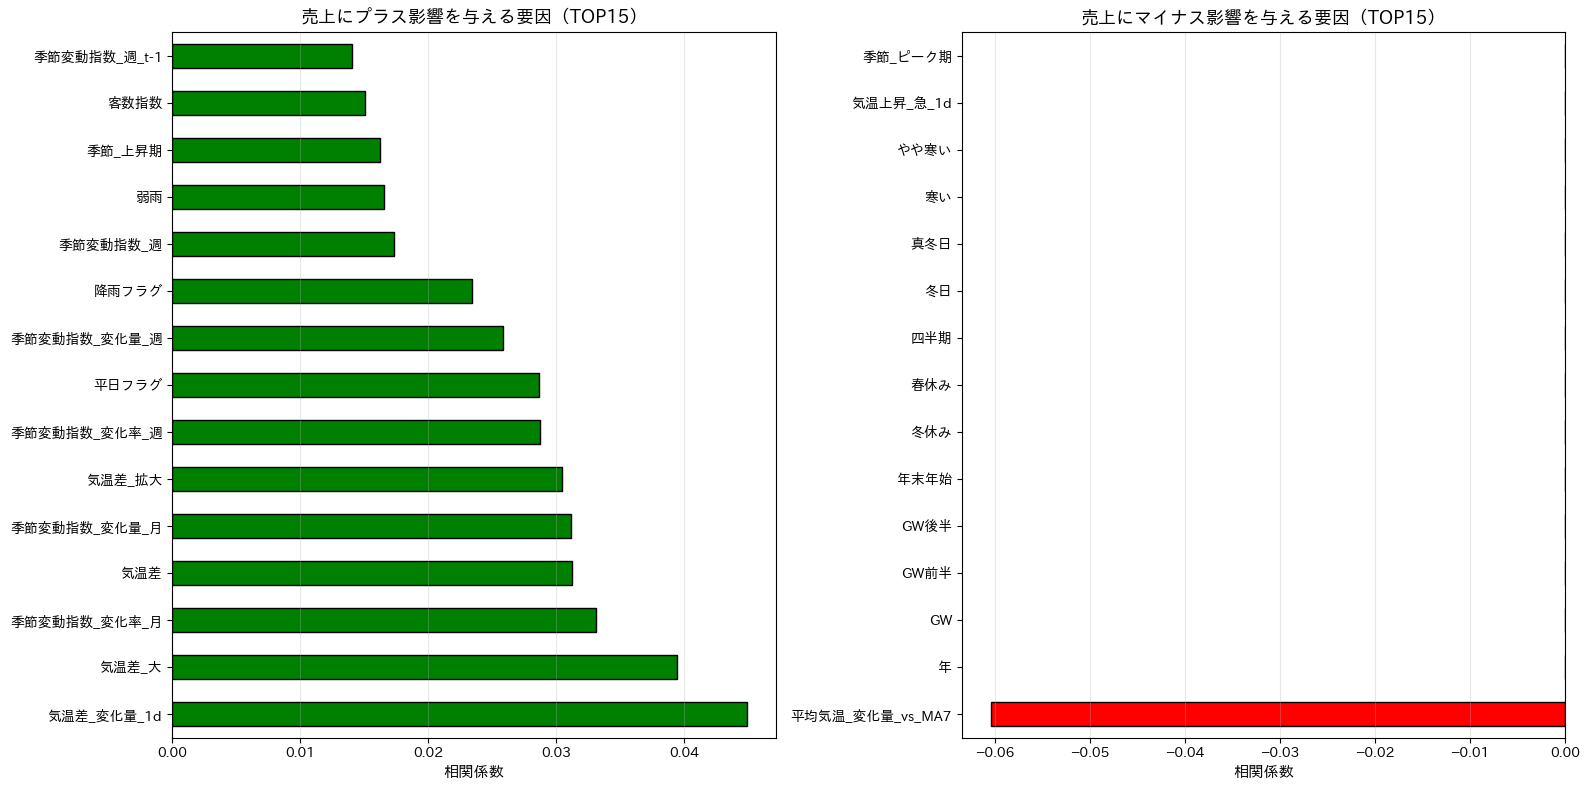


💡 業務への活用
  ✓ 正の相関が高い要因 → この条件の時は発注を増やす
  ✓ 負の相関が高い要因 → この条件の時は発注を減らす
  ✓ Stage 5のPyCaret予測モデルでこれらの特徴を活用する


In [9]:
# 数値型の外部要因特徴のみを抽出
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()

# 売上数量・売上金額は除外
exclude_cols = ['売上数量', '売上金額']
feature_cols = [col for col in numeric_features if col not in exclude_cols]

# 売上金額との相関を計算
correlations = df[feature_cols + ['売上金額']].corr()['売上金額'].drop('売上金額')
correlations = correlations.sort_values(ascending=False)

# 上位20と下位20を表示
print("="*60)
print("📊 特徴量重要度（売上金額との相関）")
print("="*60)

print("\n【正の相関（上位20）】")
print("→ 値が大きいほど売上が増える要因")
top20_corr = correlations.head(20)
for feature, corr in top20_corr.items():
    print(f"  {feature}: {corr:.3f}")

print("\n【負の相関（下位20）】")
print("→ 値が大きいほど売上が減る要因")
bottom20_corr = correlations.tail(20)
for feature, corr in bottom20_corr.items():
    print(f"  {feature}: {corr:.3f}")

# グラフ化（上位・下位各15個）
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 正の相関
top15 = correlations.head(15)
top15.plot(kind='barh', ax=axes[0], color='green', edgecolor='black')
axes[0].set_title('売上にプラス影響を与える要因（TOP15）', fontsize=13, fontproperties=JP_FP)
axes[0].set_xlabel('相関係数', fontsize=11, fontproperties=JP_FP)
axes[0].set_ylabel('', fontproperties=JP_FP)
axes[0].grid(axis='x', alpha=0.3)

# 負の相関
bottom15 = correlations.tail(15).sort_values()
bottom15.plot(kind='barh', ax=axes[1], color='red', edgecolor='black')
axes[1].set_title('売上にマイナス影響を与える要因（TOP15）', fontsize=13, fontproperties=JP_FP)
axes[1].set_xlabel('相関係数', fontsize=11, fontproperties=JP_FP)
axes[1].set_ylabel('', fontproperties=JP_FP)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 業務への活用")
print("  ✓ 正の相関が高い要因 → この条件の時は発注を増やす")
print("  ✓ 負の相関が高い要因 → この条件の時は発注を減らす")
print("  ✓ Stage 5のPyCaret予測モデルでこれらの特徴を活用する")

## 💾 9. 外部要因分析結果の保存

In [10]:
# 出力ディレクトリ
output_dir = Path('output/stage4_external_factors')
output_dir.mkdir(parents=True, exist_ok=True)

# 特徴量重要度（相関係数）
correlations_df = pd.DataFrame({
    '特徴量': correlations.index,
    '相関係数': correlations.values
})
correlations_df.to_csv(output_dir / '特徴量重要度_相関係数.csv', index=False, encoding='utf-8-sig')

# カテゴリ別気温感応度
if '最高気温' in df.columns:
    category_temp_df.to_csv(output_dir / 'カテゴリ別気温感応度.csv', index=False, encoding='utf-8-sig')

# 天気別売上
if '降雨フラグ' in df.columns:
    weather_comparison.to_csv(output_dir / '天気別売上比較.csv', encoding='utf-8-sig')

# 複合パターン別売上
if '降雨フラグ' in df.columns and '休日フラグ' in df.columns:
    pattern_stats.to_csv(output_dir / '天気×休日パターン別売上.csv', encoding='utf-8-sig')

print("✅ 外部要因分析結果を保存しました:")
print(f"   {output_dir}/")
print("\n📋 保存ファイル:")
print("  - 特徴量重要度_相関係数.csv")
if '最高気温' in df.columns:
    print("  - カテゴリ別気温感応度.csv")
if '降雨フラグ' in df.columns:
    print("  - 天気別売上比較.csv")
if '降雨フラグ' in df.columns and '休日フラグ' in df.columns:
    print("  - 天気×休日パターン別売上.csv")

✅ 外部要因分析結果を保存しました:
   output/stage4_external_factors/

📋 保存ファイル:
  - 特徴量重要度_相関係数.csv
  - カテゴリ別気温感応度.csv
  - 天気別売上比較.csv
  - 天気×休日パターン別売上.csv


## 💡 10. Stage 4 まとめ

### 外部要因分析で分かったこと
1. **気温の影響**: 気温によって売れる商品が変わる
2. **天気の影響**: 雨の日は客数が減る傾向
3. **イベント影響**: 休日・連休・給料日で売上パターンが変わる
4. **複合要因**: 複数の要因が重なると影響が増幅される
5. **特徴量重要度**: どの要因が最も売上に影響するか特定

### 実務での活用方法
```
【発注前のチェックリスト】
1. 明日の天気予報を確認（気温・降水確率）
2. カレンダーを確認（休日・イベント）
3. 気温感応度の高いカテゴリの発注を調整
4. 雨予報なら発注を抑えめに（一部商品は除く）
5. 休日・連休前は発注を増やす
```

### 次のステップ
- **Stage 5**: PyCaretで機械学習モデルを構築し、これらの外部要因を全て考慮した需要予測を行う

---